In [11]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import random
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize

In [12]:
def generate_parameters():
    difficulty = np.random.normal(loc=0, scale=1)  # Generate difficulty parameter from a normal distribution with mean 0 and std 1
    discrimination = np.random.uniform(0.5, 1.3)  # Generate discrimination parameter between 0.5 and 2
    return difficulty, discrimination

In [3]:
# questions_df=pd.read_csv('GK.csv')
# #all_questions_df['Difficulty'] = np.nan
#questions_df['Discrimination'] = np.nan

# # Assign parameters to each question
# for index, row in questions_df.iterrows():
#     difficulty, discrimination = generate_parameters()
#     #gk_questions_df.at[index, 'difficulty'] = difficulty
#     questions_df.at[index, 'Discrimination'] = discrimination
# questions_list=questions_df.to_dict(orient='records')

In [13]:
questions=pd.read_csv('GK.csv')
questions['Discrimination'] = np.nan
for index, row in questions.iterrows():
     difficulty, discrimination = generate_parameters()
     questions.at[index, 'Discrimination'] = discrimination
questions_list=questions.to_dict(orient='records')

In [20]:
questions['Category'].unique()

array(['Sports', 'Trivia', 'International Affairs',
       'Science and Technology', 'Historical Events'], dtype=object)

In [14]:
category_req={'Sports':20,
    'Trivia':20,
    'International Affairs':20,
    'Science and Technology':20,
    'Historical Events':20}

Test completed! You answered 25 out of 40 questions correctly.
Your estimated ability level is: 1.64
Your ability standard error is: 0.31


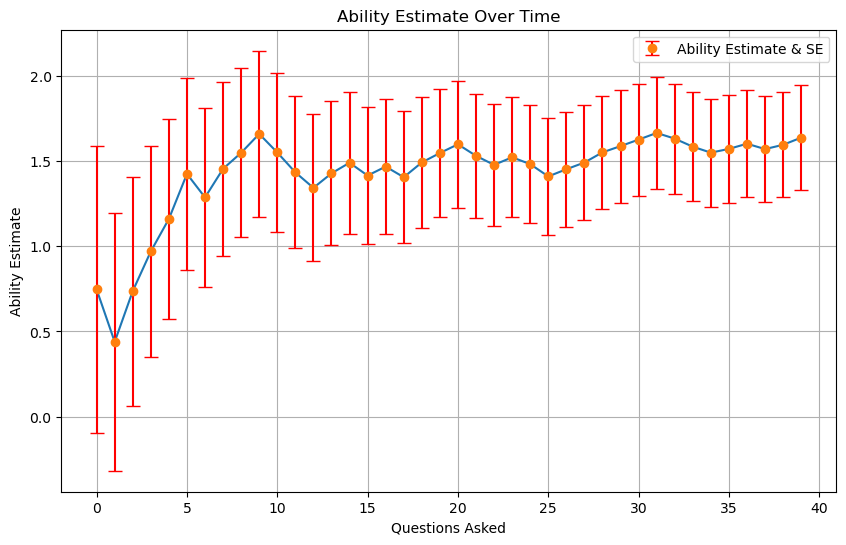

In [16]:
import matplotlib.pyplot as plt

class AdaptiveTest2PL:
    def __init__(self, questions, category_requirement, total_questions=50, prior_mean=0.55, prior_std=1.0, initial_estimate=0.5):
        self.questions = questions
        self.total_questions= total_questions
        self.asked_questions= []
        self.correct_answers= 0
        self.ability_estimate= initial_estimate  
        self.prior_mean= prior_mean
        self.prior_std= prior_std
        self.prior_variance= prior_std ** 2 
        self.ability_se= float('inf')  
        self.categories= list(set(q['Category'] for q in questions))
        self.past_categories= []  
        self.category_counts= {cat: 0 for cat in self.categories}  
        self.questions_asked= 0  
        self.difficulty_levels= []  
        self.current_ability= []  
        self.ability_se_history= []  
        self.available_questions= self.questions[:] 
        self.category_req=category_requirement
        self.cat_tolerance=2.5

    def adjust_ability(self):
        def log_posterior(ability):
            log_likelihood= 0
            for q,response in self.asked_questions:
                question= self.questions[q]
                p= self.probability_correct(ability, question)
                log_likelihood+= response* np.log(p)+ (1- response)* np.log(1- p)
            
            log_prior = -0.5* ((ability- self.prior_mean)**2)/ (self.prior_variance)
            return -(log_likelihood+ log_prior)
        
        result = minimize(log_posterior,self.ability_estimate,bounds=[(-3, 3)])
        if result.success:
            new_ability= result.x[0]
        else:
            new_ability= self.ability_estimate  
        self.current_ability.append(new_ability)
        return new_ability

    def probability_correct(self, ability, question):
        a = question['Discrimination']
        b = question['Difficulty']
        return 1 / (1 + np.exp(-a * (ability - b)))

    def update_se(self):
        fisher_info= 0
        for q,response in self.asked_questions:
            question= self.questions[q]
            p= self.probability_correct(self.ability_estimate, question)
            a= question['Discrimination']
            fisher_info+= a**2 *(p * (1 - p))

        prior_precision= 1/ self.prior_variance
        posterior_precision= prior_precision+ fisher_info
        posterior_variance= 1/ posterior_precision

        self.ability_se= np.sqrt(posterior_variance)
        self.ability_se_history.append(self.ability_se)
        return self.ability_se

    def milp_model(self):
        model = gp.Model("Question_Selection")
        
        x = model.addVars(len(self.available_questions), vtype=GRB.BINARY, name="x")
        
        ## Main Objective is to maximise Information Gain
        obj=0
        for i in range(len(self.available_questions)):
            obj+=self.expected_information_gain(self.available_questions[i], self.ability_estimate)* x[i]
        

        ## Difficulty Constraint
        for i in range(len(self.available_questions)):
              b=self.available_questions[i]['Difficulty']
              diff=np.abs(b-self.ability_estimate)
              model.addConstr(diff*x[i]<=0.8 )
        
        
        
        ## Adding category requirements as constraints will make the model infeasible during the start phase of the test.
        ## Hence converting the category constraints into penalties on objective. 
        total_asked = len(self.asked_questions) + 1  
        for cat in self.categories:
            min_proportion=(self.category_req[cat]-self.cat_tolerance)/ 100
            max_proportion=(self.category_req[cat]+self.cat_tolerance)/ 100
            category_questions= [i for i in range(len(self.available_questions)) if self.available_questions[i]['Category'] == cat]
            #min_needed= max(0,min_proportion* total_asked- self.category_counts[cat])
            #max_needed= max_proportion* total_asked- self.category_counts[cat]
            required= min_proportion*total_asked
            addition= gp.quicksum(x[i] for i in category_questions)
            deviation_above= model.addVar(vtype=GRB.CONTINUOUS)
            deviation_below= model.addVar(vtype=GRB.CONTINUOUS)
            
            
            model.addConstr(deviation_above>=self.category_counts[cat]+addition-max_proportion*total_asked)
            model.addConstr(deviation_below>= min_proportion*total_asked-self.category_counts[cat]-addition)

            model.update()
            
            obj-= 2000*deviation_below
            obj-= 2000* deviation_above  

        model.setObjective(obj,GRB.MAXIMIZE)


        ## One question per iteration constraint
        model.addConstr(gp.quicksum(x[i] for i in range(len(self.available_questions)))==1)

        return model, x
        
    def expected_information_gain(self, question, ability):
        p = self.probability_correct(ability, question)
        a = question['Discrimination']
        return a**2 * p * (1 - p)

    def get_next_question(self):
        #available_questions = [q for q in self.questions if q['question_id'] not in [q_id for q_id,response in self.asked_questions]]

        if not self.available_questions:
            print("No available question.")
            return None

        model, x = self.milp_model()
        model.optimize()

        if model.status == GRB.OPTIMAL:
            selected_question_index = next(i for i in range(len(self.available_questions)) if x[i].X > 0.5)
            selected_question = self.available_questions[selected_question_index]
            self.asked_questions.append((selected_question['question_id'], False))  
            self.past_categories.append(selected_question['Category'])
            self.category_counts[selected_question['Category']]+= 1  
            self.questions_asked += 1  
            self.difficulty_levels.append(selected_question['Difficulty'])
            self.available_questions=[q for q in self.questions if q['question_id'] not in [q for q,response in self.asked_questions]]
            return selected_question
        else:
            print("No feasible solution found by the MILP model. Relaxing constraints.")
            selected_question = random.choice(self.available_questions)
            self.asked_questions.append((selected_question['question_id'], False))  
            self.past_categories.append(selected_question['Category'])
            self.category_counts[selected_question['Category']] += 1  
            self.questions_asked += 1  
            self.difficulty_levels.append(selected_question['Difficulty'])
            return selected_question

    def ask_question(self, question):
        clear_output(wait=False)
        print(f"Question {self.questions_asked}: {question['Question']}, Category: {question['Category']}\n")
        option_buttons= []
        buttons= []
        for idx, option in enumerate([question['Option A'], question['Option B'], question['Option C'], question['Option D']]):
            button = widgets.Button(description=f"{chr(65+idx)}: {option}")
            button.on_click(partial(self.check_answer, question=question, answer=chr(65+idx)))  
            button.layout.width = 'auto'
            option_buttons.append(button)
            buttons.append(button)
        display(widgets.VBox(buttons))

    def check_answer(self, button, question, answer):
        clear_output(wait=True)
        correct_option_letter = question['Correct Option'][-1]
        correct= (answer== correct_option_letter)
        if correct:
            self.correct_answers+= 1
        self.asked_questions= [(q_id, correct) if q_id== question['question_id'] else (q_id, c) for q_id, c in self.asked_questions]
        self.ability_estimate = self.adjust_ability()
        self.ability_se = self.update_se()
        if self.questions_asked >= 20 and self.ability_se < 0.3:
            self.finish_test()
            return
        if len(self.asked_questions) < self.total_questions:
            next_question = self.get_next_question()
            if next_question:
                self.ask_question(next_question)
            else:
                self.finish_test()
        else:
            self.finish_test()

    def finish_test(self):
        clear_output(wait=True)
        print(f"Test completed! You answered {self.correct_answers} out of {self.questions_asked} questions correctly.")
        print(f"Your estimated ability level is: {self.ability_estimate:.2f}")
        print(f"Your ability standard error is: {self.ability_se:.2f}")
        fig=plt.figure(figsize=(10,6))
        plt.plot(range(len(self.current_ability)), self.current_ability)
        plt.errorbar(range(len(self.current_ability)), self.current_ability, yerr=self.ability_se_history, fmt='o', ecolor='red', capsize=5, label='Ability Estimate & SE')
        plt.xlabel('Questions Asked')
        plt.ylabel('Ability Estimate')
        plt.title('Ability Estimate Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

test = AdaptiveTest2PL(questions_list, category_requirement=category_req,prior_mean=0, initial_estimate=0.75,total_questions=40)
test.ask_question(test.get_next_question())


In [18]:
test.ability_estimate

1.1613943576483208

In [21]:
test.category_counts

{'Historical Events': 9,
 'International Affairs': 8,
 'Sports': 10,
 'Science and Technology': 4,
 'Trivia': 9}